# Simple Gaussian model fits

We fit Gaussian models as a function of period and Gaussian mixture models (with one component a flexible function of period). Also plots of the data quality of the sample.

Generates Fig. 1, 2, 3 of Sanders+ 2023.

In [134]:
%load_ext autoreload
%autoreload 2

# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import numpy as np
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import numpyro
numpyro.set_platform("gpu")

from numpyro_model import numpyro_model
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt

from data import load_mira_sample

data = load_mira_sample(lowb=False, sig_clip=3., reliable=True, 
                        high_amp=True, convert_pm=False, scale_proper_motion_errors=False)
data_lowb = load_mira_sample(lowb=True, sig_clip=3., reliable=True, 
                             high_amp=True, convert_pm=False, scale_proper_motion_errors=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single Gaussian fit models

Here mean and dispersion are flexible spline functions of the period.

In [1089]:
from functools import partial
import jax
# @partial(jax.jit, static_argnums=(0,))
@jax.jit
def logL_single(data, params):
    '''log-likelihood for a single gaussian model'''
    spl_mean=InterpolatedUnivariateSpline(data['nodes'], params['mean_values'], k=3)(data['log10period'])
    spl_cov =jnp.exp(2.*InterpolatedUnivariateSpline(data['nodes'], params['ln_std_values'], k=3)(data['log10period']))
    cov = spl_cov + data['pm_cov']
    return -.5*(jnp.log(2*jnp.pi*cov) + (data['pm']-spl_mean)**2/cov)

@jax.jit
def sm_prior(params):
    lnP=-jnp.sum(.5*(params['mean_values'][1:]-params['mean_values'][:-1])**2/params['mean_smooth']**2+jnp.log(params['mean_smooth']))
    lnP+=-jnp.sum(.5*(params['ln_std_values'][1:]-params['ln_std_values'][:-1])**2/params['ln_std_smooth']**2+jnp.log(params['ln_std_smooth']))
    return lnP

def filler(data, params):
    return np.zeros(data['log10period'].shape)

def run_spline_fit(data_lowb, compt='l',Nnodes=10, num_warmup=100, num_samples=300,shift=0.,smoothing_prior=True):
    input_data = {'log10period':jnp.array(np.log10(data_lowb['period'].values)),
                  'pm': jnp.array(data_lowb['pm'+compt].values-shift),
                  'pm_cov': jnp.array(data_lowb['epm'+compt].values**2),
                  'nodes': jnp.linspace(np.nanpercentile(np.log10(data_lowb['period'].values),.5),
                                        np.nanpercentile(np.log10(data_lowb['period'].values),99.5), Nnodes)
                }

    parameters = {'mean_values':numpyro.distributions.Normal(0.,2.).expand([Nnodes]), 
                  'ln_std_values':numpyro.distributions.Normal(1.,1.).expand([Nnodes])}
    if smoothing_prior:
        parameters['mean_smooth'] = numpyro.distributions.HalfNormal(1.)
        parameters['ln_std_smooth'] = numpyro.distributions.HalfNormal(1.)
        sm_prior_fn = sm_prior
    else:
        sm_prior_fn = None

    model = numpyro_model(logL_single, parameters, input_data, log_prior_fn=sm_prior_fn)
    model.run_mcmc(num_warmup=num_warmup, num_samples=num_samples, num_chains=8)

    return {'model':model, 'data':input_data, 'shift':shift}

def generate_sample_plot(model, label='', **kwargs):
    mN = model['data']['nodes']
    mV = model['model'].samples()['mean_values']
    mS = model['model'].samples()['ln_std_values']
    shift = model['shift']
    xx = np.linspace(2.,3.,1000)
    yy = np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(xx) for m in mV])
    yS = np.exp(np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(xx) for m in mS]))
    plt.plot(xx, np.nanpercentile(yy, 50.,axis=0) + shift, alpha=1, label=label, **kwargs)
    plt.fill_between(xx, *(np.nanpercentile(yy, [16.,84.],axis=0) + shift), alpha=0.5, **kwargs)
    plt.fill_between(xx, np.nanpercentile(yy, 50.,axis=0)-np.nanpercentile(yS, 50.,axis=0) + shift, 
                     np.nanpercentile(yy, 50.,axis=0)+np.nanpercentile(yS, 50.,axis=0) + shift, alpha=0.5, **kwargs)

model_l = run_spline_fit(data_lowb, compt='l',Nnodes=10, num_warmup=1000, num_samples=1000,shift=-7.)
model_b = run_spline_fit(data_lowb, compt='b',Nnodes=10, num_warmup=1000, num_samples=1000)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.47it/s]


In [1125]:
np.nanpercentile(data_lowb['period'],[0.5,99.5])

array([105.13807755, 844.930287  ])

In [1112]:
from jax.scipy.special import logsumexp

def logL_gmix(data, params):
    '''log-likelihood for a gaussian mixture model'''
    spl_cov = jnp.exp(2.*params['ln_std']) + data['pm_cov'][:,np.newaxis]

    return logsumexp(
        jnp.log(params['mix'])
        -.5*(data['pm'][:,np.newaxis]-params['mean'])**2/spl_cov
        -.5*jnp.log(2*jnp.pi*spl_cov),
        axis=-1
    )

def run_multi_fit(compt='l',K=2,num_warmup=100, num_samples=300,shift=0.):
    """
    Run a gaussian mixture model fit to the proper motion data

    Parameters
    ----------
    compt : str
        'l' or 'b' for l or b proper motion
    K : int
        number of components in the mixture model
    num_warmup : int
        number of warmup steps
    num_samples : int
        number of samples
    shift : float
        shift the proper motion by this amount

    Returns
    -------
    dict
        dictionary containing the model and the input data
    """
    input_data = {'pm':data_lowb['pm'+compt].values-shift,
                  'pm_cov':data_lowb['epm'+compt].values**2}

    parameters = {'mean':numpyro.distributions.TransformedDistribution(
                        numpyro.distributions.Normal(0., 1.).expand([K])
                        ,numpyro.distributions.transforms.OrderedTransform()),
                  'ln_std':numpyro.distributions.Normal(1., 2.).expand([K]), 
                  'mix':numpyro.distributions.Dirichlet(0.5 * np.ones(K))}

    model = numpyro_model(logL_gmix, parameters, input_data)
    model.run_mcmc(num_warmup=num_warmup, num_samples=num_samples)

    return {'model':model, 'data':input_data, 'shift':shift}

model_mG_l = run_multi_fit(compt='l', num_warmup=1000, num_samples=1000,shift=-7.)
model_mG_l_onecompt = run_multi_fit(compt='l', K=1, num_warmup=1000, num_samples=1000,shift=-7.)
model_mG_b = run_multi_fit(compt='b', num_warmup=1000, num_samples=1000)
model_mG_b_onecompt = run_multi_fit(compt='b', K=1, num_warmup=1000, num_samples=1000)

sample: 100%|████████████████████████████████████████| 2000/2000 [00:04<00:00, 415.84it/s, 7 steps of size 8.52e-01. acc. prob=0.93]


In [1115]:
def eval_multi_sample(model, xx, indicator=-1, N=200, err=None, **kwargs):
    # indicator = -1 means all components
    
    mV = np.nanmedian(model['model'].samples()['mean'][:N],axis=0)[np.newaxis,:]
    mS = np.nanmedian(model['model'].samples()['ln_std'][:N],axis=0)[np.newaxis,:]
    mix = np.nanmedian(model['model'].samples()['mix'][:N],axis=0)[np.newaxis,:]
    
    if err is not None:
        mS = .5 * np.log(np.exp(2.*mS) + err[:,np.newaxis]**2)

    c = np.zeros(np.shape(mix)[-1])
    if indicator==-1:
        c[:] = 1.
    else:
        c[indicator] = 1.
        
    return np.sum(c*mix*(1/(2*np.pi*np.exp(2.*mS)))**.5*np.exp(-.5*(xx[:,np.newaxis] - model['shift'] - mV)**2/np.exp(2.*mS)),axis=1)

def generate_multi_sample_plot(model, indicator=-1, label='', N=200, **kwargs):
    # indicator = -1 means all components
    xx = np.linspace(-15,15,500)
    yy = eval_multi_sample(model, xx, indicator=indicator, N=N, err=None, **kwargs)
    plt.plot(yy, xx, alpha=1, label=label, **kwargs)


def akaike_information_criterion(model, data, compt):
    L = eval_multi_sample(model, data['pm'+compt].values, err=data['epm'+compt].values)
    K = 3*np.shape(model['model'].samples()['mean'])[1]-1
    return 2*K - 2.*np.sum(np.log(L))

def bayesian_information_criterion(model, data, compt):
    L = eval_multi_sample(model, data['pm'+compt].values, err=data['epm'+compt].values)
    K = 3*np.shape(model['model'].samples()['mean'])[1]-1
    return K*np.log(len(L)) - 2.*np.sum(np.log(L))

In [1105]:
def evaluate_models(model_onecompt, model_twocompt, info_criterion, data, compt):
    if info_criterion(model_onecompt, data, compt) < info_criterion(model_twocompt, data, compt):
        return compt+': one component'
    else:
        return compt+': two components'

print(
evaluate_models(model_mG_l_onecompt, model_mG_l, akaike_information_criterion, data_lowb, 'l'),\
evaluate_models(model_mG_l_onecompt, model_mG_l, bayesian_information_criterion, data_lowb, 'l'),\
evaluate_models(model_mG_b_onecompt, model_mG_b, akaike_information_criterion, data_lowb, 'b'),\
evaluate_models(model_mG_b_onecompt, model_mG_b, bayesian_information_criterion, data_lowb, 'b')
)

l: two components l: one component b: two components b: two components


For the plots, we show the NSD-bar fraction on the sky (as in Sormani+22).

In [1028]:
import agama
from read_Portail import Portail
pp = Portail()
pp.cut_stuff()
pp.realign()
shift_sgrA=np.deg2rad(np.array([0., -0.05576432, -0.04616002]))*8.275
gc_dist=8.275
gc_vel=np.array([11.1, 6.411*4.74*8.275, 7.25])
pp.lbr=np.array(agama.getGalacticFromGalactocentric(pp.y+shift_sgrA[0],
                                                    -pp.x+shift_sgrA[1],
                                                    pp.z+shift_sgrA[2],
                                                    100.*pp.vy,
                                                    -100.*pp.vx,
                                                    100.*pp.vz, 
                                                    galcen_distance=gc_dist,
                                                    galcen_v_sun=gc_vel)).T

from sormani_potential import generate_model
df = generate_model()

reading Portail bar...
finished
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Starting iteration #1
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Starting iteration #2
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Starting iteration #3
Starting iteration #4
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Starting iteration #5
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Upda

In [1116]:
import numpy as np
import vaex
import scipy.stats as stats
from matplotlib.colors import BoundaryNorm
from kde import KDE_fft_ND

def plot_samples_ratio(x1,y1,w1,x2,y2,w2,xmin,xmax,dx,ymin,ymax,dy,aspect=None,kdesmooth='scott',alpha=0.8,filled=True,solid=True):
    xs,ys   = np.arange(xmin,xmax+dx,dx), np.arange(ymin,ymax+dy,dy)
    X,Y     = np.meshgrid(xs,ys)
    kde1    = KDE_fft_ND(np.vstack([x1,y1]).T,weights=w1,gridsize=2**12)
    kde2    = KDE_fft_ND(np.vstack([x2,y2]).T,weights=w2,gridsize=2**12)
    sigma1  = (kde1(np.vstack([X.flatten(),Y.flatten()]).T)).T.reshape(X.shape)*(w1.sum())
    sigma2  = (kde2(np.vstack([X.flatten(),Y.flatten()]).T)).T.reshape(X.shape)*(w2.sum())
    sigma   = sigma1/(sigma1+sigma2)

    return xs, ys, sigma

def make_disc_bar_ratio(pot,df,pp):

    gc_dist = 8.275

    shift_sgrA = np.deg2rad(np.array([0., -0.05576432, -0.04616002]))*gc_dist
    X, masses = agama.GalaxyModel(pot, df).sample(2000000)
    smp = vaex.from_arrays(**dict(zip(['x','y','z','vx','vy','vz'],X.T)))
    
    # Shift to put SgrA* at centre of coordinate system
    smp['x']+=shift_sgrA[0]
    smp['y']+=shift_sgrA[1]
    smp['z']+=shift_sgrA[2]

    gal = agama.getGalacticFromGalactocentric(smp['x'].values,smp['y'].values,smp['z'].values,
                                              -smp['vx'].values,-smp['vy'].values,smp['vz'].values,
                                              galcen_distance=gc_dist)
    pgal=np.array(agama.getGalacticFromGalactocentric(pp.y+shift_sgrA[0],-pp.x+shift_sgrA[1],pp.z+shift_sgrA[2],
                                                    100.*pp.vy,-100.*pp.vx,100.*pp.vz, galcen_distance=gc_dist)).T
    rangex = 2.5
    fltr = (np.abs(np.degrees(gal[0]))<rangex) & (np.abs(np.degrees(gal[1]))<rangex)
    fltr2 = (np.abs(np.degrees(pgal[:,0]))<rangex) & (np.abs(np.degrees(pgal[:,1]))<rangex)

    return plot_samples_ratio(np.degrees(gal[0][fltr]), np.degrees(gal[1][fltr]), masses[fltr],
                              np.degrees(pgal[:,0][fltr2]), np.degrees(pgal[:,1][fltr2]), pp.m[fltr2],
                              xmin=-2.0,xmax=2.0,dx=0.05,ymin=-1.5,ymax=1.5,dy=0.05,aspect='equal')

def generate_sigma_plot(xs, ys, sigma):
    levels  = levels  = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1.]
    norm    = BoundaryNorm(levels, 256)
    cmap    = 'Blues'
    alpha   = 0.5
    CS = plt.contour(xs,ys,sigma,levels=levels,colors='k',linestyles='solid',linewidths=0.5)
    CF = plt.contourf(xs,ys,sigma,levels=levels,cmap=cmap,norm=norm,alpha=alpha,extend='max')

In [1030]:
import agama
agama.setUnits(mass=1e10, length=1, velocity=1)

xsigma,ysigma,Nsigma=make_disc_bar_ratio(
                    agama.Potential(agama.Potential('../../nsd_edf/sormani_2021_potential.agama'), 
                                    agama.Potential('../../nsd_edf/portail_2017_noCNC_axi.agama')
                                    ),
                    df[1],pp)

/tmp/ipykernel_27958/812261903.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rslts = np.array([


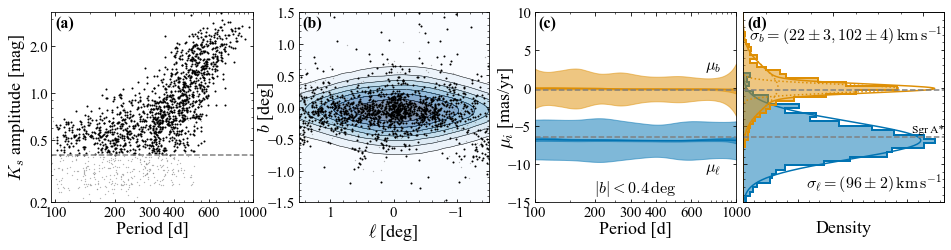

In [1117]:
## Make the data plot

import seaborn as sns
from plotting_general import add_inner_ticks
from matplotlib.ticker import ScalarFormatter, LogLocator, FuncFormatter
sns.set_palette('colorblind')
f,a=plt.subplots(1,6,figsize=[16,3.5],gridspec_kw={'width_ratios':[1,0.13,1,0.13,1,1]})
plt.subplots_adjust(wspace=0.05)
plt.sca(a[0])
plt.plot(np.log10(data_full['period']),1+np.log10(data_full['amplitude']),'.',ms=0.5,color='gray',rasterized=True)
plt.plot(np.log10(data['period']),1+np.log10(data['amplitude']),'.',ms=2,color='k',rasterized=True)
plt.axhline(np.log10(0.4)+1,color='gray',ls='dashed')
plt.xlabel('Period [day]')
plt.ylabel(r'$K_s$ amplitude [mag]')
plt.xlim(np.log10(80.),np.log10(1000.))
plt.ylim(np.log10(0.2)+1,np.log10(3.3)+1)

from plotting import format_period_axis

def format_amplitude_axis():
    axis = plt.gca().yaxis
    plt.gca().tick_params(axis="y",direction="in")
    plt.gca().tick_params(axis="y",direction="in",which='minor')
    plt.gca().yaxis.set_ticks_position('both')
    axis.set_major_locator(LogLocator(subs=1+np.log10(np.array([0.1,0.2,0.5,1.,2.,5.]))))
    axis.set_minor_locator(LogLocator(subs=1+np.log10(np.array([0.3,0.4,0.6,0.7,0.8,0.9,3.]))))
    axis.set_major_formatter(FuncFormatter(lambda x, pos:'%0.1f'%np.power(10.,x-1)))

format_period_axis(False)
format_amplitude_axis()

a[1].axis('off')

plt.sca(a[2])

generate_sigma_plot(xsigma,ysigma,Nsigma)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

swl = lambda l: l-360.*(l>180.)
plt.plot(swl(data_full['l']),data_full['b'],'.',ms=0.5,color='gray',rasterized=True)
dfltr = (data_full['unreliable']==0)&(data_full['amplitude']>0.4)
plt.plot(swl(data_full['l'][dfltr]),data_full['b'][dfltr],'.',ms=2,color='k',rasterized=True)
plt.gca().set_aspect('equal')
add_inner_ticks()
plt.xlabel(r'$\ell$ [deg]')
plt.ylabel(r'$b$ [deg]')
plt.gca().yaxis.labelpad = -8
plt.gca().invert_xaxis()

a[3].axis('off')
plt.sca(a[4])
generate_sample_plot(model_l,color=sns.color_palette()[0],label=r'$\mu_\ell$')
generate_sample_plot(model_b,color=sns.color_palette()[1],label=r'$\mu_b$')
# plt.plot(np.log10(data['period']),data['pmb'],'.')
plt.ylim(-15,10)
plt.xlim(np.log10(100.),np.log10(1000.))
plt.axhline(-6.41,color='gray',ls='dashed')
plt.axhline(-7.25/4.74/8.275,color='gray',ls='dashed')
plt.xlabel(r'Period [day]')
plt.ylabel(r'$\mu_i$ [mas/yr]')
plt.gca().yaxis.labelpad = -8
# plt.legend(loc='upper center',ncol=2,frameon=False,fontsize=16,handlelength=1)
plt.annotate(r'$\mu_\ell$',xy=(np.log10(700),-11),xycoords='data',fontsize=16)
plt.annotate(r'$\mu_b$',xy=(np.log10(700),2.5),xycoords='data',fontsize=16)

plt.annotate(r'$|b|<0.4\,\mathrm{deg}$',xy=(0.5,0.02),xycoords='axes fraction',fontsize=16,ha='center',va='bottom')

format_period_axis(False)
plt.xlim(np.log10(100.),np.log10(1000.))

plt.sca(a[5])
plt.hist(data['pml'],orientation='horizontal',color=sns.color_palette()[0],histtype='step',lw=2,bins=30,density=True)
plt.hist(data['pml'],orientation='horizontal',color=sns.color_palette()[0],histtype='stepfilled',lw=2,bins=30,alpha=0.5,density=True)
generate_multi_sample_plot(model_mG_l_onecompt, color=sns.color_palette()[0])
# generate_multi_sample_plot(model_mG_l_onecompt, indicator=0, color=sns.color_palette()[0], ls='dotted')
# generate_multi_sample_plot(model_mG_l_onecompt, indicator=1, color=sns.color_palette()[0], ls='dotted')
plt.gca().set_xticklabels([])
add_inner_ticks()
plt.xlabel('Density')
plt.gca().xaxis.labelpad = 15

plt.twiny()
plt.hist(data['pmb'],orientation='horizontal',color=sns.color_palette()[1],histtype='step',lw=2,bins=30,density=True)
plt.hist(data['pmb'],orientation='horizontal',color=sns.color_palette()[1],histtype='stepfilled',lw=2,bins=30,alpha=0.5,density=True)
generate_multi_sample_plot(model_mG_b, color=sns.color_palette()[1])
generate_multi_sample_plot(model_mG_b, indicator=0, color=sns.color_palette()[1], ls='dotted')
generate_multi_sample_plot(model_mG_b, indicator=1, color=sns.color_palette()[1], ls='dotted')
plt.ylim(-15,10)
plt.axhline(-6.41,color='gray',ls='dashed')
plt.axhline(-7.25/4.74/8.275,color='gray',ls='dashed')
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
axis = plt.gca().xaxis
plt.gca().minorticks_on()
plt.gca().tick_params(axis="x",direction="in")
plt.gca().tick_params(axis="x",direction="in",which='minor')
plt.gca().xaxis.set_ticks_position('top')

plt.annotate(r'$\sigma_\ell = (%i\pm%i)\,\mathrm{km\,s}^{-1}$'%(
    
    np.exp(np.nanmedian(np.array(model_mG_l_onecompt['model'].samples()['ln_std'])))*4.74*8.275,
    .5*np.diff(np.exp(np.nanpercentile(np.array(model_mG_l_onecompt['model'].samples()['ln_std']),[16.,84.])))*4.74*8.275),
             xy=(0.99,0.1),xycoords='axes fraction',ha='right',va='center',fontsize=16)
rslts = np.array([
    np.exp(np.nanmedian(np.array(model_mG_b['model'].samples()['ln_std'][:,1])))*4.74*8.275,
    .5*np.diff(np.exp(np.nanpercentile(np.array(model_mG_b['model'].samples()['ln_std'][:,1]),[16.,84.])))*4.74*8.275,
             np.exp(np.nanmedian(np.array(model_mG_b['model'].samples()['ln_std'][:,0])))*4.74*8.275,
             .5*np.diff(np.exp(np.nanpercentile(np.array(model_mG_b['model'].samples()['ln_std'][:,0]),[16.,84.])))*4.74*8.275])
if rslts[0]>rslts[2]:
    rslts = rslts[[2,3,0,1]]
plt.annotate(r'$\sigma_b = (%i\pm%i,%i\pm%i)\,\mathrm{km\,s}^{-1}$'%tuple(rslts),
             xy=(0.99,0.88),xycoords='axes fraction',ha='right',va='center',fontsize=16)
plt.annotate('Sgr A*',xy=(plt.gca().get_xlim()[1],-6.01),xycoords='data',ha='right',va='bottom',fontsize=11.5)

plt.sca(a[0])
plt.annotate('(a)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[2])
plt.annotate('(b)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[4])
plt.annotate('(c)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[5])
plt.annotate('(d)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')

plt.savefig('plots/data_summary_plot.pdf', bbox_inches='tight')


In [1118]:
np.nanmedian(model_mG_b['model'].samples()['mean'][:,0])*8.275*4.74 ,\
.5*np.diff(np.nanpercentile(model_mG_b['model'].samples()['mean'][:,0],[16.,84.])*8.275*4.74 )[0],\
np.nanmedian(model_mG_b['model'].samples()['mean'][:,1])*8.275*4.74 ,\
.5*np.diff(np.nanpercentile(model_mG_b['model'].samples()['mean'][:,1],[16.,84.])*8.275*4.74 )[0]

(-1.98086557706818, 1.6555393010547295, 2.542756255544722, 2.5284336552330853)

/tmp/ipykernel_27958/3933268477.py:46: RuntimeWarning: overflow encountered in power
  axis.set_major_formatter(FuncFormatter(lambda x, pos:'%i'%np.int64(np.power(10.,x)*1.0001)))
/tmp/ipykernel_27958/3933268477.py:46: RuntimeWarning: overflow encountered in power
  axis.set_major_formatter(FuncFormatter(lambda x, pos:'%i'%np.int64(np.power(10.,x)*1.0001)))


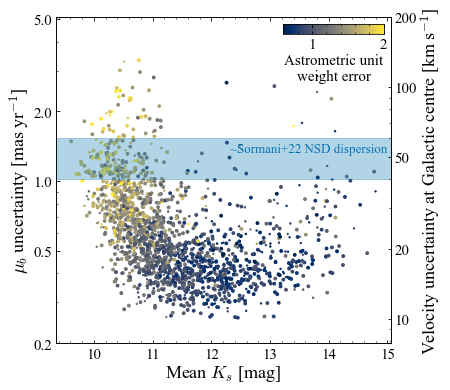

In [1049]:
# Data quality plots

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=[6,6])
import seaborn as sns
sns.set_palette('colorblind')

ylim = np.array([0.2,5.1])*10.
plt.ylim(*np.log10(ylim))
C=plt.scatter(data_full['Ks_mean_data'],np.log10(data_full['epmb'])+1,s=2,rasterized=True,
c=data_full['uwe'].values,vmax=2,vmin=0.6,cmap=plt.cm.cividis);
C=plt.scatter(data['Ks_mean_data'],np.log10(data['epmb'])+1,s=8,rasterized=True,
c=data['uwe'].values,vmax=2,vmin=0.6,cmap=plt.cm.cividis);
# insert colorbar floating in plot
ax = plt.gca()
cbaxes = inset_axes(plt.gca(), width="30%", height="3%", loc='upper right') 
cbar=plt.colorbar(C,cax=cbaxes, orientation='horizontal',pad=0.1,shrink=0.8)
add_inner_ticks()
cbar.set_label('Astrometric unit\nweight error',fontsize=15)
plt.sca(ax)

axis = plt.gca().xaxis
plt.gca().tick_params(axis="x",direction="in")
plt.gca().tick_params(axis="x",direction="in",which='minor')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().minorticks_on()
axis = plt.gca().yaxis
plt.gca().tick_params(axis="y",direction="in")
plt.gca().tick_params(axis="y",direction="in",which='minor')
plt.gca().yaxis.set_ticks_position('both')
axis.set_major_locator(LogLocator(subs=1+np.log10(np.array([0.1,0.2,0.5,1.,2.,5.]))))
axis.set_minor_locator(LogLocator(subs=1+np.log10(np.array([0.3,0.4,0.6,0.7,0.8,0.9,3.,4.]))))
axis.set_major_formatter(FuncFormatter(lambda x, pos:'%0.1f'%np.power(10.,x-1)))
plt.ylabel(r'$\mu_b$ uncertainty [mas yr$^{-1}$]')
plt.xlabel(r'Mean $K_s$ [mag]')

ax=plt.twinx()
plt.ylim(*np.log10((ylim/10.)*4.74*8.275))

plt.gca().minorticks_on()
axis = ax.yaxis
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="y",direction="in",which='minor')
ax.yaxis.set_ticks_position('right')
axis.set_major_locator(LogLocator(subs=1+np.log10(np.array([0.1,0.2,0.5,1.,2.,5.,10.,20.,50.,100.,200.]))))
axis.set_minor_locator(LogLocator(subs=1+np.log10(np.array([0.3,0.4,0.6,0.7,0.8,0.9,3.,4.,6,7,8,9,30,40,60.,70.,80.,90.]))))
axis.set_major_formatter(FuncFormatter(lambda x, pos:'%i'%np.int64(np.power(10.,x)*1.0001)))
plt.ylabel(r'Velocity uncertainty at Galactic centre [km s$^{-1}$]')

plt.axhspan(np.log10(40.),np.log10(60.),color=sns.color_palette()[0],alpha=0.3)
plt.annotate('~Sormani+22 NSD dispersion',xy=(15,np.log10(57.)),xycoords='data',
             ha='right',va='top',fontsize=13,color=sns.color_palette()[0])

plt.savefig('plots/uncertainty_vs_Ks.pdf', bbox_inches='tight')

In [1050]:
np.nanmedian(data['epmb']),np.nanmedian(data['epmb'])*4.74*8.275,\
np.nanmedian(data['epml']),np.nanmedian(data['epml'])*4.74*8.275

(0.5420177484339855, 21.25983315570043, 0.552015850219882, 21.651993701099542)

## Multi-component Gaussian fit models

Here we fit a mixture of Gaussians to the data with one component having a dispersion that is a flexible function of period.

In [576]:
import jax.numpy as jnp
import jax.scipy as jsp

from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

def logL_two_compt_uncorrelated_cov(data, params):
    """UNUSED"""
    
    # Ndata, Ncompts, 2, 2
    spl_mix  =InterpolatedUnivariateSpline(data['nodes'], params['mix_values'], k=3)(data['period'])
    
    spl_mix = 1-jnp.exp(-spl_mix)
    
    cov = params['primary_std']**2*np.eye(2)
    inv_cov_p =  jnp.linalg.inv(data['pm_cov']+cov)
    X_mu = (data['pm']-params['primary_mean'])
    
    cov = params['outlier_std']**2*np.eye(2)
    inv_cov_p_out =  jnp.linalg.inv(data['pm_cov']+cov[jnp.newaxis,:,:])
    X_mu_out = (data['pm']-params['outlier_mean'][jnp.newaxis,:])
    
    return jnp.logaddexp(
        (jnp.log(1-spl_mix)
               -.5*jnp.sum(X_mu * jnp.matmul(inv_cov_p, X_mu[:,:,jnp.newaxis])[:,:,0],axis=-1)
               +.5*jnp.log(jnp.linalg.det(inv_cov_p))),
        (jnp.log(spl_mix)
               -.5*jnp.sum(X_mu_out * jnp.matmul(inv_cov_p_out, X_mu_out[:,:,jnp.newaxis])[:,:,0],axis=-1)
               +.5*jnp.log(jnp.linalg.det(inv_cov_p_out)))
        )


def logL_uncorrelated_cov_onecompt(data, params):
    """UNUSED"""
    
    # Ndata, Ncompts, 2, 2
    spl_meanb=InterpolatedUnivariateSpline(data['nodes'], params['mean_b_values'], k=3)(data['period'])
    spl_stdb =jnp.exp(InterpolatedUnivariateSpline(data['nodes'], params['ln_std_b_values'], k=3)(data['period']))
    spl_mix  =InterpolatedUnivariateSpline(data['nodes'], params['mix_values'], k=3)(data['period'])
    spl_mix = 1-jnp.exp(-spl_mix)
    
    if jnp.any(spl_stdb>params['ln_outlier_std']):
        return -jnp.inf

    return jnp.logaddexp(
        (jnp.log(1-spl_mix)
               -.5*(data['pm']-spl_meanb)**2/jnp.hypot(data['epm'],spl_stdb)**2
               -jnp.log(jnp.hypot(data['epm'],spl_stdb))),
        (jnp.log(spl_mix)
               -.5*(data['pm']-params['outlier_mean'])**2/jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))**2
               -jnp.log(jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))))
        )

def logL_uncorrelated_cov(data, params):
    """UNUSED"""
    # Ndata, Ncompts, 2, 2
    spl_meanl=InterpolatedUnivariateSpline(data['nodes'], params['mean_l_values'], k=3)(data['period'])
    spl_meanb=InterpolatedUnivariateSpline(data['nodes'], params['mean_b_values'], k=3)(data['period'])
    spl_stdl =InterpolatedUnivariateSpline(data['nodes'], params['std_l_values'], k=3)(data['period'])
    spl_stdb =InterpolatedUnivariateSpline(data['nodes'], params['std_b_values'], k=3)(data['period'])
    spl_mix  =InterpolatedUnivariateSpline(data['nodes'], params['mix_values'], k=3)(data['period'])
    
    spl_mix = 1-jnp.exp(-spl_mix)
    
    spl_mean = jnp.vstack([spl_meanl, spl_meanb]).T
    spl_std = jnp.vstack([spl_stdl, spl_stdb]).T
    
    cov = spl_std[:,jnp.newaxis,:]**2*np.eye(2)
    inv_cov_p =  jnp.linalg.inv(data['pm_cov']+cov)
    X_mu = (data['pm']-spl_mean)
    
    cov = params['outlier_std']**2*np.eye(2)
    inv_cov_p_out =  jnp.linalg.inv(data['pm_cov']+cov[jnp.newaxis,:,:])
    X_mu_out = (data['pm']-params['outlier_mean'][jnp.newaxis,:])
    
    return jnp.logaddexp(
        (jnp.log(1-spl_mix)
               -.5*jnp.sum(X_mu * jnp.matmul(inv_cov_p, X_mu[:,:,jnp.newaxis])[:,:,0],axis=-1)
               +.5*jnp.log(jnp.linalg.det(inv_cov_p))),
        (jnp.log(spl_mix)
               -.5*jnp.sum(X_mu_out * jnp.matmul(inv_cov_p_out, X_mu_out[:,:,jnp.newaxis])[:,:,0],axis=-1)
               +.5*jnp.log(jnp.linalg.det(inv_cov_p_out)))
        )



def logL_uncorrelated_cov_onecompt_zeromean(data, params):
    
    # Ndata, Ncompts, 2, 2
    spl_stdb =jnp.exp(InterpolatedUnivariateSpline(data['nodes'], params['ln_std_b_values'], k=3)(data['period']))
    spl_mix  =InterpolatedUnivariateSpline(data['nodes'], params['mix_values'], k=3)(data['period'])
    spl_mix = 1-jnp.exp(-spl_mix)
    
    return jnp.logaddexp(
        (jnp.log(1-spl_mix)
               -.5*(data['pm']-0.)**2/jnp.hypot(data['epm'],spl_stdb)**2
               -jnp.log(jnp.hypot(data['epm'],spl_stdb))),
        (jnp.log(spl_mix)
               -.5*(data['pm']-0.)**2/jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))**2
               -jnp.log(jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))))
        )

def logL_uncorrelated_cov_onecompt_fixweight_zeromean(data, params):
    
    # Ndata, Ncompts, 2, 2
    spl_meanb=0.
    spl_stdb =jnp.exp(InterpolatedUnivariateSpline(data['nodes'], params['ln_std_b_values'], k=3)(data['period']))
    spl_mix  =params['mix_value']
    spl_mix = 1-jnp.exp(-spl_mix)
    
    return jnp.logaddexp(
        (jnp.log(1-spl_mix)
               -.5*(data['pm']-spl_meanb)**2/jnp.hypot(data['epm'],spl_stdb)**2
               -jnp.log(jnp.hypot(data['epm'],spl_stdb))),
        (jnp.log(spl_mix)
               -.5*(data['pm']-0.)**2/jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))**2
               -jnp.log(jnp.hypot(data['epm'],jnp.exp(params['ln_outlier_std']))))
        )

In [482]:
## Testing against emcee
from scipy.interpolate import UnivariateSpline
from scipy.special import logsumexp as logsumexp_scipy
def logl(p,x,y,yerr2,Nnodes,pp, mean_zero=True, fixed_weight=False, fixed_dispersion=False):
    
    if not mean_zero:
        m = p[:Nnodes]
        um = UnivariateSpline(pp,m,k=3,s=0)
        m_ = um(x)
    else:
        m_ = np.zeros_like(x)

    if not fixed_dispersion:
        lns = p[Nnodes*(not mean_zero):Nnodes+Nnodes*(not mean_zero)]
        ulns = UnivariateSpline(pp,lns,k=3,s=0)
        s2_ = np.exp(2*ulns(x))
    else:
        S2 = np.exp(p[(Nnodes)*(not mean_zero)]*2.)
        if S2>1.25**2:
            return -np.inf
        s2_ = np.ones_like(x) * S2

    if not fixed_weight:
        lneps = p[1+Nnodes*(not mean_zero)+(Nnodes-1)*(not fixed_dispersion):1+Nnodes*(not mean_zero)+(Nnodes-1)*(not fixed_dispersion)+Nnodes]
        ulne = UnivariateSpline(pp,lneps,k=3,s=0)
        lne_ = ulne(x)
    else:
        lne_ = np.ones_like(x) * p[1+Nnodes*(not mean_zero)+(Nnodes-1)*(not fixed_dispersion)]
    
    if not mean_zero:
        outlierm, outlierlns = p[2+(Nnodes)*(not mean_zero)+(Nnodes-1)*(not fixed_dispersion)+(Nnodes-1)*(not fixed_weight):]
    else:
        outlierlns = p[2+(Nnodes)*(not mean_zero)+(Nnodes-1)*(not fixed_dispersion)+(Nnodes-1)*(not fixed_weight)]
        outlierm = m_
    
    os2 = np.exp(outlierlns*2.)
    o = -.5*(y-outlierm)**2/(os2+yerr2)-.5*np.log(yerr2+os2)

    if(np.any(lne_>0) or np.any(s2_>os2)):
        return -np.inf
    
    return np.sum(logsumexp_scipy([np.log(1-np.exp(lne_))-.5*(y-m_)**2/(yerr2+s2_)-.5*np.log(yerr2+s2_),
                                   lne_+o],axis=0))#-outlierlns

import emcee
Nnodes=5
nwalkers = (3*Nnodes+2)*2
pp = np.linspace(np.log10(120.),np.log10(900.),Nnodes)

compt='b'
mean_zero=True
fixed_weight=True
fixed_dispersion=False
ndim = (Nnodes+1)*(not mean_zero) + (not fixed_dispersion)*(Nnodes-1) + (not fixed_weight)*(Nnodes-1) + 3

em_b = emcee.EnsembleSampler(nwalkers=nwalkers,ndim=ndim, log_prob_fn=logl, 
                           args=(np.log10(data_lowb['period'].values), 
                                 data_lowb['pmb'].values, 
                                 data_lowb['epmb'].values**2, Nnodes, pp, mean_zero, fixed_weight, fixed_dispersion),
                           threads=32)
p0 = np.concatenate([[np.nanmean(data_lowb['pmb'].values)]*(Nnodes*(not mean_zero)),
                     [20./4.74/8.275]*((Nnodes-1)*(not fixed_dispersion)+1),
                     np.ones(1+(Nnodes-1)*(not fixed_weight))*-.5,
                     np.array([0]*(not mean_zero)),
                     np.array([2.5])])
p0 = p0[:,np.newaxis]+np.random.normal(0.,0.1,size=(ndim, nwalkers))
rr_b=em_b.run_mcmc(p0.T,1000)

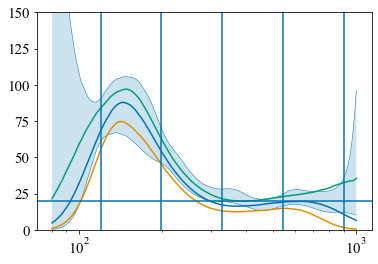

In [1053]:
## Checking emcee implementation vs. numpyro
mN = model.data['nodes']
mV = model.samples()['ln_std_b_values']
ppu = np.linspace(np.log10(80.),np.log10(1000.),200)
yy = np.exp(np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(ppu) for m in mV]))
plt.fill_between(np.power(10.,ppu), np.nanpercentile(yy, 16.,axis=0)/fac, np.nanpercentile(yy, 84.,axis=0)/fac,alpha=0.2)
plt.plot(np.power(10.,ppu), np.nanpercentile(yy, [16.,84.],axis=0).T/fac, color=sns.color_palette('colorblind')[0], lw=0.5)

pp = np.linspace(np.log10(120.),np.log10(900.),5)
ppu = np.linspace(np.log10(80.),np.log10(1000.),200)
plt.plot(np.power(10.,ppu),4.74*8.275*np.nanmedian(np.exp(np.array([UnivariateSpline(pp,m,k=3,s=0)(ppu) for m in em_b.flatchain[:,:-2][-15000:]])),axis=0))
plt.plot(np.power(10.,ppu),4.74*8.275*np.nanpercentile(np.exp(np.array([UnivariateSpline(pp,m,k=3,s=0)(ppu) for m in em_b.flatchain[:,:-2][-15000:]])),16.,axis=0))
plt.plot(np.power(10.,ppu),4.74*8.275*np.nanpercentile(np.exp(np.array([UnivariateSpline(pp,m,k=3,s=0)(ppu) for m in em_b.flatchain[:,:-2][-15000:]])),84.,axis=0))

plt.ylim(0.,150.)
plt.semilogx()
plt.axhline(20.)
[plt.axvline(np.power(10.,p)) for p in pp]

In [812]:
Nnodes = 10

input_data = {'period':jnp.array(np.log10(data_lowb['period'].values)),
              'pm':data_lowb['pmb'].values+7./(4.74*8.275),
              'epm':data_lowb['epmb'].values,
              'nodes':np.linspace(np.log10(120.),np.log10(900.),Nnodes)}

@jax.jit
def smoothing_prior(params):
    lnP = -jnp.sum(.5*(params['ln_std_b_values'][1:]-params['ln_std_b_values'][:-1])**2/(params['ln_std_b_smooth'])**2 + jnp.log(params['ln_std_b_smooth']))
    if 'mix_values' in params:
      lnP += -jnp.sum(.5*(params['mix_values'][1:]-params['mix_values'][:-1])**2/(params['mix_smooth'])**2 + jnp.log(params['mix_smooth']))
    return lnP

def run_fit(use_fix_weight = True, prior=smoothing_prior):

    parameters = {
                'ln_std_b_values':numpyro.distributions.Normal(0.,2.0).expand([Nnodes]), 
                'ln_outlier_std':numpyro.distributions.Normal(1.,0.5),
                'ln_std_b_smooth':numpyro.distributions.HalfNormal(5.),
                }
    
    if use_fix_weight:
        parameters['mix_value'] = numpyro.distributions.HalfNormal(2.)
        LL_fn = logL_uncorrelated_cov_onecompt_fixweight_zeromean
    else:
        parameters['mix_values'] = numpyro.distributions.HalfNormal(2.).expand([Nnodes])
        parameters['mix_smooth'] = numpyro.distributions.HalfNormal(5.)
        LL_fn = logL_uncorrelated_cov_onecompt_zeromean

    model = numpyro_model(LL_fn, parameters, input_data, log_prior_fn=prior)
    model.run_mcmc(num_warmup=1000, num_samples=2000)
    return model

model = run_fit(use_fix_weight = True, prior=smoothing_prior)
model_marg = run_fit(use_fix_weight = False, prior=smoothing_prior)

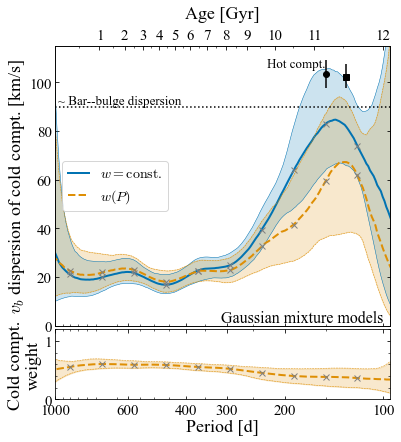

In [1139]:
f,a=plt.subplots(2,1,figsize=[6,6.5], gridspec_kw={'height_ratios':[2.,0.5]})
plt.subplots_adjust(hspace=0.02)
plt.sca(a[0])
mN = model.data['nodes']
mV = model.samples()['ln_std_b_values']
ppu = np.linspace(np.log10(80.),np.log10(1000.),200)
yy = np.exp(np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(ppu) for m in mV]))
plt.fill_between(ppu, np.nanpercentile(yy, 16.,axis=0)/fac, np.nanpercentile(yy, 84.,axis=0)/fac,alpha=0.2)
plt.plot(ppu, np.nanpercentile(yy, [16.,84.],axis=0).T/fac, color=sns.color_palette('colorblind')[0], lw=0.5)
plt.plot(ppu, np.nanpercentile(yy, 50.,axis=0)/fac, color=sns.color_palette('colorblind')[0], lw=2, label=r'$w=\mathrm{const.}$')
plt.plot(mN, np.nanmedian(np.exp(model.samples()['ln_std_b_values'])/fac, axis=0), 'x', color='gray')

mN = model_marg.data['nodes']
mV = model_marg.samples()['ln_std_b_values']
ppu = np.linspace(np.log10(80.),np.log10(1000.),200)
yy = np.exp(np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(ppu) for m in mV]))
plt.fill_between(ppu, np.nanpercentile(yy, 16.,axis=0)/fac, np.nanpercentile(yy, 84.,axis=0)/fac,alpha=0.2,
                 color=sns.color_palette('colorblind')[1])
plt.plot(ppu, np.nanpercentile(yy, [16.,84.],axis=0).T/fac, ls='dashed', color=sns.color_palette('colorblind')[1], lw=0.5)
plt.plot(ppu, np.nanpercentile(yy, 50.,axis=0)/fac, ls='dashed', color=sns.color_palette('colorblind')[1], lw=2, label=r'$w(P)$')
plt.legend(loc='center left', handlelength=1.5)
plt.plot(mN, np.nanmedian(np.exp(model_marg.samples()['ln_std_b_values'])/fac, axis=0), 'x', color='gray')

# yS = np.exp(np.array([scipy.interpolate.InterpolatedUnivariateSpline(model_b['data']['nodes'],m,k=3)(xx) 
#                       for m in model_b['model'].samples()['ln_std_values']]))
# plt.plot(xx, np.nanpercentile(yS, 50.,axis=0)*4.74*8.275)

plt.ylim(0.,115.)
plt.xlim(np.log10(80.),np.log10(900.))
plt.xlabel('Period [days]')
plt.ylabel('$v_b$ dispersion of cold compt. [km/s]')

plt.axhline(90.,ls='dotted', color='k')
plt.annotate('~ Bar--bulge dispersion', xy=(np.log10(980.),90.), xycoords='data', ha='left', va='bottom', fontsize=13, color='k')
plt.annotate('Hot compt.', xy=(np.log10(150.),105.), xycoords='data', ha='right', va='bottom', fontsize=13, color='k')

plt.annotate('Gaussian mixture models', xy=(np.log10(100.),0.), xycoords='data', ha='right', va='bottom', fontsize=16, color='k')

plt.errorbar([np.log10(150.)],
             np.nanpercentile(np.exp(np.array(model.samples()['ln_outlier_std']))/fac, 50.),
             yerr=np.array([[
                     np.nanpercentile(np.exp(np.array(model.samples()['ln_outlier_std']))/fac, 50.)
                    -np.nanpercentile(np.exp(np.array(model.samples()['ln_outlier_std']))/fac, 16.),
                     np.nanpercentile(np.exp(np.array(model.samples()['ln_outlier_std']))/fac, 84.)
                    -np.nanpercentile(np.exp(np.array(model.samples()['ln_outlier_std']))/fac, 50.)]]).T,
            color='k',fmt='o')


plt.errorbar([np.log10(130.)],
             np.nanpercentile(np.exp(np.array(model_marg.samples()['ln_outlier_std']))/fac, 50.),
             yerr=np.array([[
                     np.nanpercentile(np.exp(np.array(model_marg.samples()['ln_outlier_std']))/fac, 50.)
                    -np.nanpercentile(np.exp(np.array(model_marg.samples()['ln_outlier_std']))/fac, 16.),
                    np.nanpercentile(np.exp(np.array(model_marg.samples()['ln_outlier_std']))/fac, 84.)
                    -np.nanpercentile(np.exp(np.array(model_marg.samples()['ln_outlier_std']))/fac, 50.)]]).T,
            color='k',fmt='s')

plt.xlim(100.,1000.)
ax=plt.gca()
format_period_axis()
plt.gca().invert_xaxis()
ax.invert_xaxis()
ax.set_xlabel('')
ax.set_xticklabels([])
# shade_bfa()

plt.sca(a[1])

mN = model_marg.data['nodes']
mV = model_marg.samples()['mix_values']
ppu = np.linspace(np.log10(80.),np.log10(1000.),200)
yy = np.exp(-np.array([scipy.interpolate.InterpolatedUnivariateSpline(mN,m,k=3)(ppu) for m in mV]))
plt.fill_between(ppu, np.nanpercentile(yy, 16.,axis=0), np.nanpercentile(yy, 84.,axis=0),alpha=0.2, color=sns.color_palette('colorblind')[1])

plt.plot(ppu, np.nanpercentile(yy, [16.,84.],axis=0).T, ls='dashed', color=sns.color_palette('colorblind')[1], lw=0.5)
plt.plot(ppu, np.nanpercentile(yy, 50.,axis=0), ls='dashed', color=sns.color_palette('colorblind')[1], lw=2)

plt.plot(mN, np.nanmedian(np.exp(-model_marg.samples()['mix_values']), axis=0), 'x', color='gray')

add_inner_ticks()
format_period_axis(False)
plt.gca().invert_xaxis()
plt.ylim(0.,1.2)
plt.ylabel('Cold compt.\nweight')
plt.savefig('plots/mixture_model_period.pdf', bbox_inches='tight')


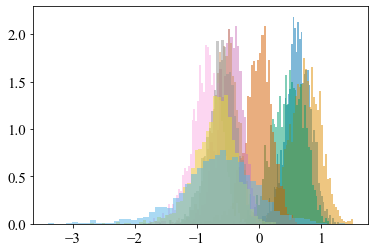

In [1054]:
[plt.hist(np.array(model.samples()['ln_std_b_values'][:,i]),bins=50,density=True,alpha=0.5) for i in range(10)];